In [1]:
%matplotlib inline

import os
import random
import fnmatch
import datetime
import pickle
import sys
import glob
import math
import h5py
import numpy as np

import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

Using TensorFlow backend.


tf.__version__: 2.1.0
keras.__version__: 2.3.1


In [2]:
model_output_dir = './nvidia_model'
datasetDirTrain = './dataset/'
datasetFilesTrain = glob.glob(datasetDirTrain+'*.h5')

<HDF5 file "carla-dataset-2021-03-21.h5" (mode r)>
KeysView(<HDF5 file "carla-dataset-2021-03-21.h5" (mode r)>)
(1156, 160, 384, 3)
(1156,)
1156


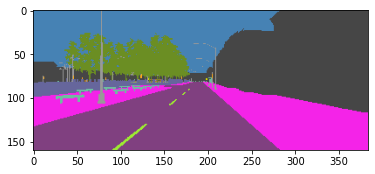

In [3]:
dataset = h5py.File(datasetFilesTrain[0], 'r')

print(dataset)
print(dataset.keys())
print(dataset['rgb'].shape)
print(dataset['measurements'].shape)

ind = 2
x = dataset['rgb'][ind]
size_dataset = len(dataset['rgb']) 
plt.imshow(x)
dataset.close()
print(size_dataset)

In [4]:
images = []
steering_angles = []
batch_data_siz = 1
speed = []
gas = []
brake = []
data_in = []
data_out = []

for idData in range(0,batch_data_siz):
    try:
        dataset = h5py.File(datasetFilesTrain[idData], 'r')
        for idx in range(0,size_dataset):
            angle = math.degrees(math.acos(dataset['measurements'][idx][0]))
            if not( angle >= 89 and angle <=91 and random.uniform(0, 1) > 0.08):
                gas_d = dataset['measurements'][idx][1]
                brake_d = dataset['measurements'][idx][2]
                vel_d = dataset['measurements'][idx][3]
                steering_angles.append(angle)
                images.append(dataset['rgb'][idx])
                speed.append(vel_d)
                gas.append(gas_d)
                brake.append(brake_d)
                data_in.append([dataset['rgb'][idx], vel_d, 1])
                data_out.append([angle, gas_d, brake_d])

        dataset.close()
    except: 
        print(datasetFilesTrain[idData])

df = pd.DataFrame()
df['ImagePath'] = images
df['Angle'] = steering_angles
df['Speed'] = speed
df['Gas'] = gas
df['Brake'] = brake
print('len angles {}'.format(str(len(steering_angles))))

len angles 426


(array([6.0000, 5.0000, 6.0000, 5.0000, 6.0000, 3.0000, 11.0000, 11.0000,
        3.0000, 10.0000, 7.0000, 26.0000, 97.0000, 44.0000, 24.0000,
        7.0000, 50.0000, 45.0000, 12.0000, 15.0000, 10.0000, 7.0000,
        7.0000, 6.0000, 3.0000]),
 array([64.1320, 66.2321, 68.3322, 70.4323, 72.5324, 74.6325, 76.7326,
        78.8327, 80.9328, 83.0329, 85.1330, 87.2331, 89.3333, 91.4334,
        93.5335, 95.6336, 97.7337, 99.8338, 101.9339, 104.0340, 106.1341,
        108.2342, 110.3343, 112.4344, 114.5346, 116.6347]),
 <BarContainer object of 25 artists>)

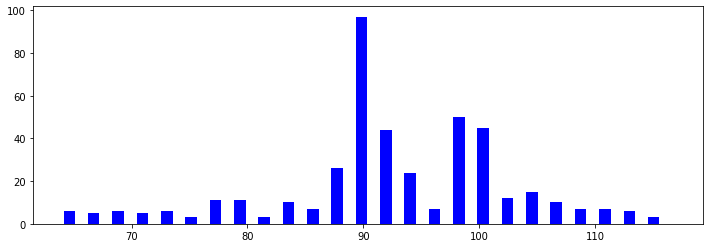

In [5]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

(array([7.0000, 5.0000, 8.0000, 361.0000, 14.0000, 7.0000, 4.0000, 5.0000,
        1.0000, 0.0000, 3.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 2.0000, 2.0000, 2.0000, 1.0000, 1.0000,
        1.0000]),
 array([0.2693, 0.2703, 0.2712, 0.2722, 0.2731, 0.2741, 0.2750, 0.2760,
        0.2769, 0.2779, 0.2789, 0.2798, 0.2808, 0.2817, 0.2827, 0.2836,
        0.2846, 0.2856, 0.2865, 0.2875, 0.2884, 0.2894, 0.2903, 0.2913,
        0.2922, 0.2932]),
 <BarContainer object of 25 artists>)

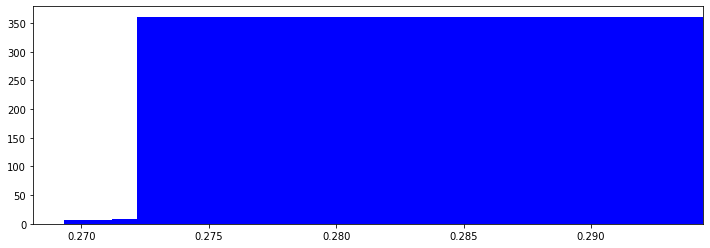

In [6]:
num_of_bins = 25
hist, bins = np.histogram(df['Gas'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Gas'], bins=num_of_bins, width=1, color='blue')

(array([1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 4.0000,
        1.0000, 2.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 3.0000, 3.0000, 4.0000, 9.0000, 335.0000, 43.0000, 8.0000,
        6.0000]),
 array([2.2335, 2.2353, 2.2371, 2.2389, 2.2407, 2.2425, 2.2443, 2.2461,
        2.2479, 2.2497, 2.2515, 2.2533, 2.2551, 2.2569, 2.2587, 2.2605,
        2.2623, 2.2641, 2.2659, 2.2677, 2.2695, 2.2713, 2.2731, 2.2749,
        2.2767, 2.2785]),
 <BarContainer object of 25 artists>)

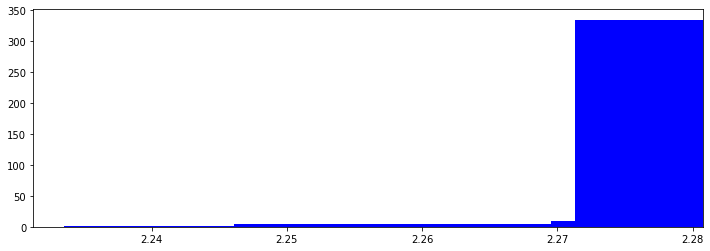

In [7]:
num_of_bins = 25
hist, bins = np.histogram(df['Speed'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Speed'], bins=num_of_bins, width=1, color='blue')

Training data: 340
Validation data: 86


Text(0.5, 1.0, 'Validation Data')

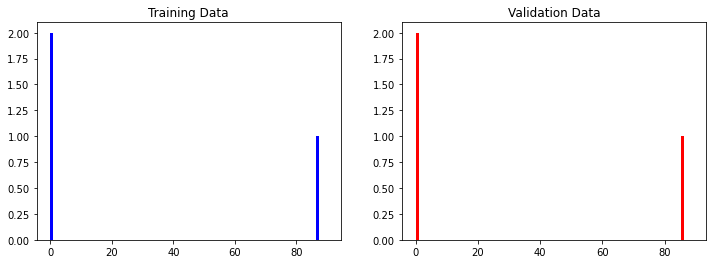

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split( data_in, data_out, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train[0], bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid[0], bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

In [9]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_flip(image, steering_angle):
    #is_flip = random.randint(0, 1)
    #if is_flip == 1:
        # randomly flip horizon
    #    image = cv2.flip(image,1)
    #    steering_angle = -1 * steering_angle
   
    return image, steering_angle

def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle

Text(0.5, 1.0, 'processed')

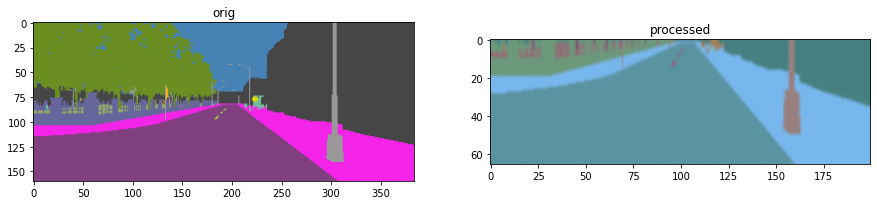

In [10]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66))
    image = image / 255 
    return image

image_index = 2
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = images[image_index]
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [11]:
def image_data_generator(data_in, data_out, batch_size, is_training):
    while True:
        batch_images = []
        batch_vector = []
        batch_output = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(data_in) - 1)
            image = data_in[random_index][0]
            speed = data_in[random_index][1]
            command = 1
            steering_angle = data_out[random_index][0]
            gas = data_out[random_index][1] 
            brake = data_out[random_index][2]
            
            if is_training:
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_vector.append([speed])
            batch_output.append([steering_angle, gas, brake, speed])

        #yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
        yield ({'image': np.asarray(batch_images), 'vector': np.asarray(batch_vector)}, {'output': np.asarray(batch_output)})

In [13]:
def nvidia_model():
    # Define two input layers
    image_input = Input((66, 200, 3), name='image')
    vector_input = Input((1,), name='vector')

    # Convolution + Flatten for the image
    conv_layer = Conv2D(24, (5, 5), strides=(2, 2), activation='elu')(image_input)
    
    conv_layer = Conv2D(36, (5, 5), strides=(2, 2), activation='elu')(conv_layer)
    conv_layer = Conv2D(48, (5, 5), strides=(2, 2), activation='elu')(conv_layer)
    conv_layer = Conv2D(64, (3, 3), activation='elu') (conv_layer)
    conv_layer = Dropout(0.2)(conv_layer)
    conv_layer = Conv2D(64, (3, 3), activation='elu')(conv_layer)
    
    conv_layer = Flatten()(conv_layer)
    conv_layer = Dropout(0.2)(conv_layer)
    conv_layer = Dense(100, activation='elu')(conv_layer)
    conv_layer = Dense(50, activation='elu')(conv_layer)
    conv_layer = Dense(10, activation='elu')(conv_layer)
    
    flat_layer = Flatten()(conv_layer)

    vector_input_ly = Dense(128)(vector_input)
    vector_input_ly =Dense(128)(vector_input_ly)

    # Concatenate the convolutional features and the vector input
    concat_layer= Concatenate()([vector_input_ly, flat_layer])
    concat_layer = Dense(512)(concat_layer)
    concat_layer = Dense(256)(concat_layer)
    concat_layer = Dense(256)(concat_layer)
    output = Dense(4, name='output')(concat_layer)

    # define a model with a list of two inputs
    model = Model(inputs=[image_input, vector_input], outputs=output)
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
model = nvidia_model()
plot_model(model,to_file='nvidia.png',show_shapes=True)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 66, 200, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 98, 24)   1824        image[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 47, 36)   21636       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 5, 22, 48)    43248       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=200, is_training=True),
                              steps_per_epoch=300,
                              epochs=5,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Instructions for updating:
Please use Model.fit, which supports generators.
  {'output': '...'}
    to  
  ['...']
  {'output': '...'}
    to  
  ['...']
Train for 300 steps, validate for 200 steps
Epoch 1/5
299/300 [============================>.] - ETA: 0s - loss: 53.0239 - accuracy: 0.9967
Epoch 00001: val_loss improved from inf to 8.15428, saving model to ./nvidia_model/lane_navigation_check.h5
300/300 [==============================] - 171s 569ms/step - loss: 52.8947 - accuracy: 0.9967 - val_loss: 8.1543 - val_accuracy: 1.0000
Epoch 2/5
299/300 [============================>.] - ETA: 0s - loss: 9.2847 - accuracy: 1.0000
Epoch 00002: val_loss improved from 8.15428 to 1.97187, saving model to ./nvidia_model/lane_navigation_check.h5
300/300 [==============================] - 150s 499ms/step - loss: 9.2793 - accuracy: 1.0000 - val_loss: 1.9719 - val_accuracy: 1.0000
Epoch 3/5
299/300 [============================>.] - ETA: 0s - loss: 4.3430 - accuracy: 1.0000
Epoch 00003: val_loss imp

In [17]:
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

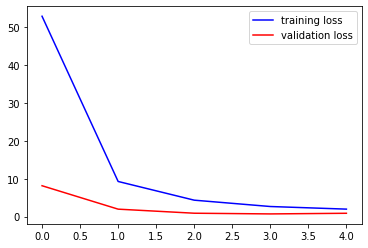

In [18]:
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

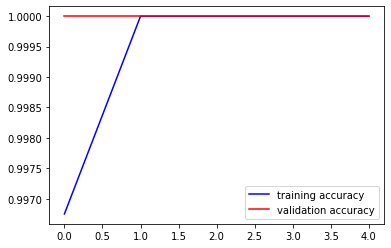

In [19]:
plt.plot(history['accuracy'],color='blue')
plt.plot(history['val_accuracy'],color='red')
plt.legend(["training accuracy", "validation accuracy"])

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y['output'], Y_pred)
    return Y_pred

mse       = 0.67
r_squared = -45632.82%



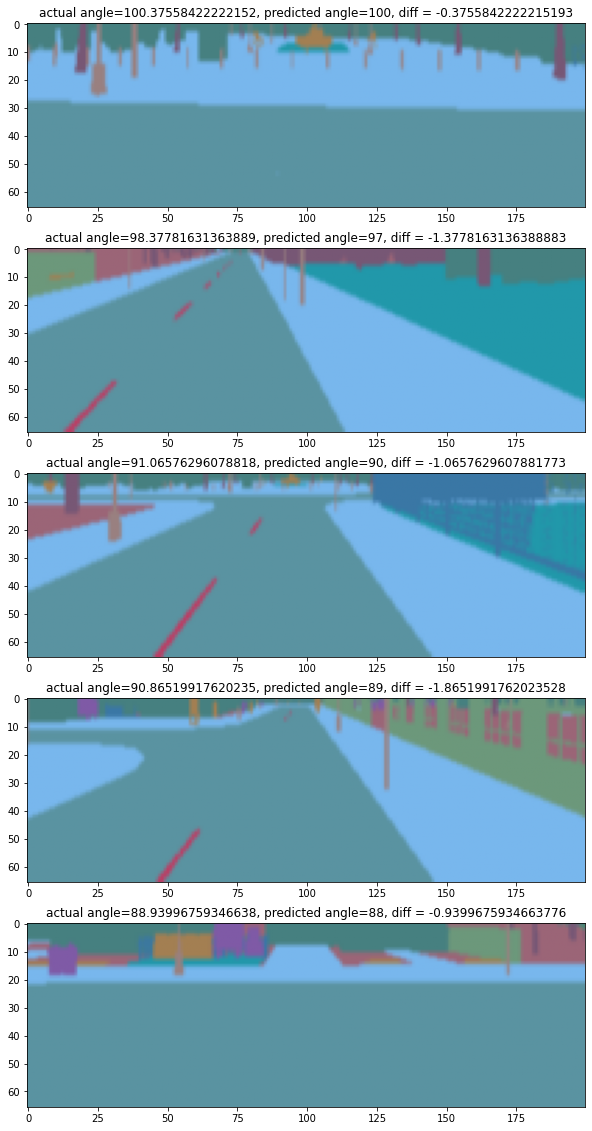

In [21]:
n_tests = 10
X_test, y_test = next(image_data_generator(X_valid, y_valid, 10, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 5
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test['image'][i])
    axes[i].set_title(f"actual angle={y_test['output'][i][0]}, predicted angle={int(y_pred[i][0])}, diff = {int(y_pred[i][0])-y_test['output'][i][0]}")

mse       = 1.1
r_squared = -93660.04%



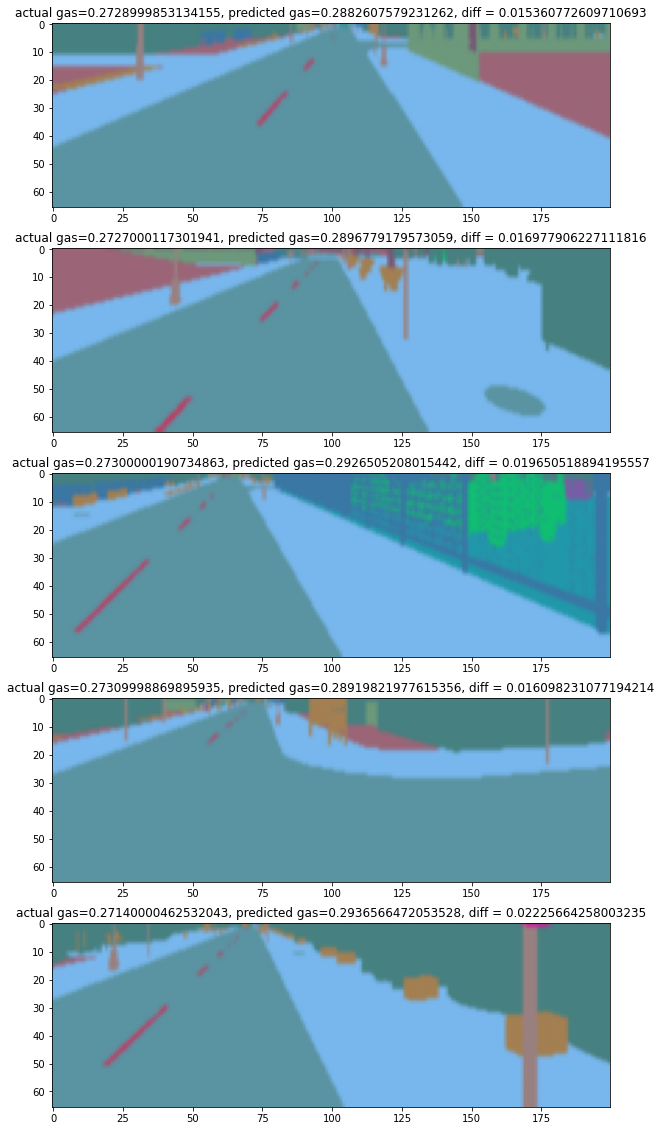

In [22]:
n_tests = 10
X_test, y_test = next(image_data_generator(X_valid, y_valid, 10, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 5
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test['image'][i])
    axes[i].set_title(f"actual gas={y_test['output'][i][1]}, predicted gas={y_pred[i][1]}, diff = {y_pred[i][1]-y_test['output'][i][1]}")